In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, expon
from scipy import  stats
import simpy

## Ejercicio 1
A partir del universo de página webs provistas junto al enunciado, se pide:
* Calcular el pagerank para cada sitio. (Mostrar la matriz generada)
* Simular 20 búsquedas de palabras elegidas al azar dentro de las existentes en los textos de las páginas, y
mostrar las mismas en función de la importancia asignada a cada sitio.

Para construir la matriz vamos a tener en cuenta dos casos:
1) Si el sitio actual referencia a otros sitios, todos los sitios referenciados tendrán la misma probabilidad de ser visitados en el próximo instante de tiempo.
2) Si el sitio actual no referencia a ningun otro sitio, todos los sitios en su totalidad tendrán la misma probabilidad de ser visitados en el próximo instante de tiempo.

A partir de esto, podemos construir la matriz que nos ayuda a comprender el comportamiento en cuestión.
Cada sitio está representado como un posible estado siguiendo la siguiente convención:
* Estado 0: Angelina Jolie
* Estado 1: Brad Pitt
* Estado 2: Jennifer Aniston
* Estado 3: Jon Voight
* Estado 4: Martin Scorcese
* Estado 5: Robert De Niro

Siendo $p_{i,j}$ la probabilidad de pasar del estado i al estado j, la matriz sigue la siguiente forma 

\begin{equation}
P = 
\begin{bmatrix}
p_{0,0} & p_{0,1} & p_{0,2} & p_{0,3} & p_{0,4} & p_{0,5}\\
p_{1,0} & p_{1,1} & p_{1,2} & p_{1,3} & p_{1,4} & p_{1,5}\\
p_{2,0} & p_{2,1} & p_{2,2} & p_{2,3} & p_{2,4} & p_{2,5}\\
p_{3,0} & p_{3,1} & p_{3,2} & p_{3,3} & p_{3,4} & p_{3,5}\\
p_{4,0} & p_{4,1} & p_{4,2} & p_{4,3} & p_{4,4} & p_{4,5}\\
p_{5,0} & p_{5,1} & p_{5,2} & p_{5,3} & p_{5,4} & p_{5,5}\\
\end{bmatrix}
\end{equation}

Completamos las probabilidades y obtenemos:

\begin{equation}
P = 
\begin{bmatrix}
0 & 1/2 & 0 & 1/2 & 0 & 0\\
1/2 & 0 & 1/4 & 0 & 1/4 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
2/3 & 1/3 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 1 & 0\\
\end{bmatrix}
\end{equation}

Luego, para calcular el pagerank de cada sitio vamos a buscar la distribución estacionaria de la cadena de Markov que a su vez representa la probabilidad de terminar en cada uno de los estados para un instante de tiempo tendiendo al infinito

### Cálculo de pagerank 

Primero nos aseguramos que converge, para ello chequeamos los autovalores:

In [ ]:
p = np.array([ [0,1/2,0,1/2,0,0],
               [1/2,0,1/4,0,1/4,0],
              [1/6,1/6,1/6,1/6,1/6,1/6],
              [2/3,1/3,0,0,0,0],
              [1/6,1/6,1/6,1/6,1/6,1/6],
              [0,0,0,0,1,0]
             ])

avas,avec = np.linalg.eig(p)
print("Autovalores: \nλ1= {}\nλ2= {}\nλ3= {}\nλ4= {}\nλ5= {}\nλ6= {}\n".format(avas[0], avas[1],avas[2],avas[3],avas[4],avas[5]))

Autovalores: 
λ1= 1.0
λ2= 0.45424145588351783
λ3= -0.6873305299176353
λ4= -0.26691092596588245
λ5= -5.551115123125783e-17
λ6= -0.16666666666666657



Como podemos ver, a excepción de λ1 que es igual a 1, para los demás autovalores se cumple que son menores a 1 en valor absoluto. Esto es una condición suficiente para poder afirmar que hay convergencia.

Un camino posible es plantear

$$
\begin{equation}
[\pi_1,\pi_2,\pi_3,\pi_4,\pi_5,\pi_6] * 
\begin{bmatrix}
0 & 1/2 & 0 & 1/2 & 0 & 0\\
1/2 & 0 & 1/4 & 0 & 1/4 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
2/3 & 1/3 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 1 & 0\\
\end{bmatrix}
= [\pi_1,\pi_2,\pi_3,\pi_4,\pi_5,\pi_6]
\end{equation}
$$

De modo que queda resolver el siguiente sistema de ecuaciones:

$
\pi_1 = \frac{1}{2}\pi_2 + \frac{1}{6}\pi_3 + \frac{2}{3}\pi_4 + \frac{1}{6}\pi_5\\
\pi_2 = \frac{1}{2}\pi_1 + \frac{1}{6}\pi_3 + \frac{1}{3}\pi_4 + \frac{1}{6}\pi_5\\
\pi_3 = \frac{1}{4}\pi_2 + \frac{1}{6}\pi_3 + \frac{1}{6}\pi_5\\
\pi_4 = \frac{1}{2}\pi_1 + \frac{1}{6}\pi_3 + \frac{1}{6}\pi_5\\
\pi_5 = \frac{1}{4}\pi_2 + \frac{1}{6}\pi_3 + \frac{1}{6}\pi_5 + \pi_6\\ 
\pi_6 = \frac{1}{6}\pi_3 + \frac{1}{6}\pi_5\\
1 = \pi_1 + \pi_2 + \pi_3 + \pi_4 + \pi_5 + \pi_6
$

In [ ]:
A = np.array([ [-1,1/2,1/6,2/3,1/6,0],
               [1/2,-1,1/6,1/3,1/6,0],
              [0,1/4,-5/6,0,1/6,0],
              [1/2,0,1/6,-1,1/6,0],
              [0,1/4,1/6,0,-5/6,1],
              [1,1,1,1,1,1]
             ])
b = np.array([0, 0, 0, 0, 0,1])
x = np.linalg.solve(A, b)

print("Distrbución estacionaria:\nπ1= {}\nπ2= {}\nπ3= {}\nπ4= {}\nπ5= {}\nπ6= {}".format(x[0],x[1],x[2],x[3],x[4],x[5]))

Distrbución estacionaria:
π1= 0.2857142857142857
π2= 0.24489795918367344
π3= 0.10204081632653059
π4= 0.18367346938775508
π5= 0.1428571428571429
π6= 0.040816326530612346


Por otro lado, si elevamos la matriz P a un numero lo suficientemente grande, deberíamos observar que aparecen estos valores en las columnas. Comprobemoslo

In [ ]:
result = np.linalg.matrix_power(p, 50)
result

array([[0.28571429, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633],
       [0.28571428, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633],
       [0.28571429, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633],
       [0.28571428, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633],
       [0.28571429, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633],
       [0.28571429, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
        0.04081633]])

Efectivamente se cumple. Entonces, el page rank queda:

In [ ]:
page_rank = pd.DataFrame(data={'Id':[0,1,3,4,2,5],'Nombre':['Angelina Jolie','Brad Pitt','Jon Voight','Martin Scorcese','Jennifer Aniston','Robert De Niro']}) 
page_rank

Id            Nombre
0   0    Angelina Jolie
1   1         Brad Pitt
2   3        Jon Voight
3   4   Martin Scorcese
4   2  Jennifer Aniston
5   5    Robert De Niro

### Resultados de búsquedas

In [ ]:
def obtener_lista_palabras(texto):
    lista_palabras = texto.replace('.','').replace(',', '').replace('(','').replace(')','').replace(';','').split(" ")
    return lista_palabras

In [ ]:
sitio0 = obtener_lista_palabras("Angelina Jolie (born Angelina Jolie Voight; June 4, 1975) is an American actress and Goodwill Ambassador for the UN Refugee Agency. She has received three Golden Globe Awards, two Screen Actors Guild Awards, and an Academy Award. Jolie has promoted humanitarian causes throughout the world, and is noted for her work with refugees through UNHCR. She has been cited as one of the world's most beautiful women and her off-screen life is widely reported.[1] Though she made her screen debut as a child alongside her father Jon Voight in the 1982 film Lookin' to Get Out, Jolie's acting career began in earnest a decade later with the low-budget production Cyborg 2 (1993). Her first leading role in a major film was in Hackers (1995). She starred in the critically acclaimed biographical films George Wallace (1997) and Gia (1998), and won an Academy Award for Best Supporting Actress for her performance in the drama Girl, Interrupted (1999). Jolie achieved wider fame after her portrayal of video game heroine Lara Croft in Lara Croft: Tomb Raider (2001), and since then has established herself as one of the best-known and highest-paid actresses in Hollywood.[2] She has had her biggest commercial successes with the action-comedy Mr. & Mrs. Smith (2005) and the animated film Kung Fu Panda (2008).[3] Divorced from actors Jonny Lee Miller and Billy Bob Thornton, Jolie currently lives with actor Brad Pitt, in a relationship that has attracted worldwide media attention. Jolie and Pitt have three adopted children, Maddox, Pax, and Zahara, as well as three biological children, Shiloh, Knox, and Vivienne.")
sitio1 = obtener_lista_palabras("William Bradley 'Brad' Pitt[1] (born December 18, 1963) is an American actor and film producer. He has been cited as one of the world's most attractive men, a label that entices the media to report on his off-screen life.[2][3] Pitt has received two Academy Award nominations and four Golden Globe Award nominations, winning one. Pitt began his acting career with television guest appearances, which included a role on the CBS soap opera Dallas in 1987. He gained recognition as the cowboy hitchhiker who seduces Geena Davis's character in the 1991 road movie Thelma & Louise. Pitt's first leading roles in big-budget productions came with A River Runs Through It (1992) and Interview with the Vampire (1994). He was cast opposite Anthony Hopkins in the 1994 drama Legends of the Fall, which earned him his first Golden Globe nomination. In 1995, he gave critically acclaimed performances in the crime thriller Seven and the science fiction film Twelve Monkeys, the latter earning him a Golden Globe Award for Best Supporting Actor and an Academy Award nomination. Four years later in 1999, Pitt starred in the cult hit Fight Club. Subsequently in 2001, he starred in the major international hit Ocean's Eleven and its sequels Ocean's Twelve (2004) and Ocean's Thirteen (2007). He has had his biggest commercial successes with Troy (2004) and Mr. & Mrs. Smith (2005). Pitt received his second Academy Award nomination for his performance in the title role in the 2008 film The Curious Case of Benjamin Button. Following a high-profile relationship with actress Gwyneth Paltrow, Pitt was married to actress Jennifer Aniston for five years. As of 2009, he lives with actress Angelina Jolie in a relationship that has attracted worldwide media attention.[4] He and Jolie have three adopted children, Maddox, Zahara, and Pax, and have also given birth to three biological children, Shiloh, Knox, and Vivienne. Pitt owns a production company named Plan B Entertainment, which produced the 2007 Academy Award winner for Best Picture, Martin Scorcese's The Departed, among other films. Since beginning his relationship with Jolie, he has become increasingly involved in social issues, both in the United States and internationally.")
sitio2 = obtener_lista_palabras("Jennifer Joanna Aniston (born February 11, 1969) is an American actress. She became famous in the 1990s for her role as Rachel Green in the US sitcom Friends, a role for which she won an Emmy Award, a Golden Globe Award, and a Screen Actors Guild Award. She has starred in several Hollywood films. While most of her film roles have been in comedies such as Bruce Almighty, Office Space, Rumor Has It, and the romantic comedies Along Came Polly and The Break-Up, she has also appeared in films from other genres, such as the comedy-horror Leprechaun and the crime thriller Derailed.")
sitio3 = obtener_lista_palabras("Jonathan Vincent 'Jon' Voight (born December 29, 1938) is an American film and television actor. He has had a long and distinguished career as both a leading man and, in recent years, a character actor, with an extensive and compelling range. He came to prominence at the end of the 1960s, with a performance as a would-be hustler in 1969's Best Picture winner, Midnight Cowboy, for which he earned his first Academy Award nomination. Throughout the following decades, Voight built his reputation with an array of challenging roles and has appeared in such landmark films as Deliverance (1972), and Coming Home (1978), for which he received an Academy Award for Best Actor. Voight's impersonation of sportscaster/journalist Howard Cosell, in the 2001 biopic Ali, earned Voight critical raves and his fourth Oscar nomination. He has starred in the seventh season of 24 as the villain Jonas Hodges. Voight is the father of actress Angelina Jolie and actor James Haven, as well as brother of singer-songwriter Chip Taylor and geologist Barry Voight. He has six grandchildren by Jolie and her partner Brad Pitt.")
sitio4 = obtener_lista_palabras("Martin Marcantonio Luciano Scorsese (born November 17, 1942) is an American film director, screenwriter, producer, actor, and film historian. He is the founder of the World Cinema Foundation and a recipient of the AFI Life Achievement Award for his contributions to the cinema and has won awards from the Oscars, Golden Globe, BAFTA, and Directors Guild of America. Scorsese is president of the Film Foundation, a non-profit organization dedicated to film preservation and the prevention of the decaying of motion picture film stock. Scorsese's body of work addresses such themes as Italian American identity, Roman Catholic concepts of guilt and redemption,[1] machismo, and violence. Scorsese is widely considered to be one of the most significant and influential American filmmakers of his era, directing landmark films such as Taxi Driver, Raging Bull and Goodfellas; all of which he collaborated on with actor Robert De Niro.[2] He earned the Academy Award for Best Director for The Departed and an MFA in film directing from the New York University Tisch School of the Arts.")
sitio5 = obtener_lista_palabras("Robert Mario De Niro, Jr. (born August 17, 1943) is an American actor, director, and producer. De Niro is well known for his method acting and portrayals of conflicted, troubled characters and for his enduring collaboration with director Martin Scorsese. He gained critical acclaim in the early 1970s, culminating in his first Academy Award as best Supporting Actor for The Godfather Part II (1974), followed by a Best Actor Academy Award win for Raging Bull (1980). His film roles include the young Vito Corleone in The Godfather Part II, cabbie Travis Bickle in Taxi Driver, boxer Jake LaMotta in Raging Bull, mobster Jimmy Conway in Goodfellas and Jack Byrnes in Meet the Parents and Meet the Fockers.")

palabras_totales = sitio0+sitio1+sitio2+sitio3+sitio4+sitio5

In [ ]:
#Definimos funcion que se encarga de buscar la palabra devolviendo los resultados correspondientes
def simular_busqueda_palabra(palabra_buscada):
    nro_resultado = 1
    print(f"   \tResultados: ")
    for sitio in [[sitio0,"Angelina Jolie"],[sitio1,"Bradd Pitt"],[sitio2,"Jennifer Aniston"],[sitio3,"Jon Voight"],[sitio4,"Martin Scorcese"],[sitio5,"Robert De Niro"]]:
        if (palabra_buscada in sitio[0]): 
            print(f"\t{nro_resultado}. {sitio[1]}")
            nro_resultado += 1

cantidad_palabras = 20

for i in range(0,cantidad_palabras):
    palabra_buscada = palabras_totales[np.random.randint(0,len(palabras_totales),1)[0]]
    print(f"\n-> Palabra {i+1}: \033[1m{palabra_buscada}\033[0m")
    simular_busqueda_palabra(palabra_buscada)
    


-> Palabra 1: era
   	Resultados: 
	1. Martin Scorcese

-> Palabra 2: the
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Jennifer Aniston
	4. Jon Voight
	5. Martin Scorcese
	6. Robert De Niro

-> Palabra 3: Goodfellas
   	Resultados: 
	1. Martin Scorcese
	2. Robert De Niro

-> Palabra 4: internationally
   	Resultados: 
	1. Bradd Pitt

-> Palabra 5: directing
   	Resultados: 
	1. Martin Scorcese

-> Palabra 6: been
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Jennifer Aniston

-> Palabra 7: 1992
   	Resultados: 
	1. Bradd Pitt

-> Palabra 8: actor
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Jon Voight
	4. Martin Scorcese
	5. Robert De Niro

-> Palabra 9: acting
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Robert De Niro

-> Palabra 10: of
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Jennifer Aniston
	4. Jon Voight
	5. Martin Scorcese
	6. Robert De Niro

-> Palabra 11: the
   	Resultados: 
	1. Angelina Jolie
	2. Bradd Pitt
	3. Jennifer A

## Ejercicio 2
En base a lo presentado en el trabajo “Queuing theory application in imaging service analysis for small Earth observation satellites”,
simular los resultados obtenidos sobre la longitud de imágenes en cola esperando ser procesadas en la sección 3.1. Pure image capture service system.
El ejercicio se puede resolver utilizando simpy o programación tradicional (a elección del grupo)

Para simular los resultados, utiliceramos Simpy mediante el cual modelaremos la cola de request las cuales serán atendidas por un único servidor.

Los tiempos de arribos de las requests siguen una distribución exponencial de media $1/\lambda$, siendo $\lambda$ la tasa de arribos de requests por día. A su vez, tenemos $\mu_0$, que representa la tasa de servicio base, dado a que dicha tasa varía en función de la cantidad de requests que hayan en la cola, de modo que la tasa de servicios será $\mu_0 * n$

In [ ]:
class SimuladorCola:
    def __init__(self, _tasa_arribos, _tasa_servicio, _arribos):
        self.tasa_arribos = _tasa_arribos
        self.tasa_servicio = _tasa_servicio
        self.capacidad_servicio = 1
        self.tiempos = []
        self.request_en_espera = []
        self.arribos_totales = _arribos
        self.tasas_servicios = []

    # Dado que las request tienen una prioridad de acuerdo a la mayor oportunidad para capturar
    # la imagen, se asignó una prioridad al azar.
    def simular_prioridad(self):
        return np.random.randint(1,5)

    def generar_arribos_requests(self, env, res):
        arribos = 0
        while arribos < self.arribos_totales:
            yield env.timeout(np.random.exponential(1/self.tasa_arribos)) #
            arribos += 1
            prioridad = self.simular_prioridad()
            #print(f"Request {arribos}: Sacar foto con prioridad {prioridad} arribó en tiempo {env.now}")
            env.process(self.servicio_de_captura(env, res, prioridad))

    def servicio_de_captura(self, env, res, prioridad):
        request = res.request(priority=prioridad)
        # Aguarda liberacion del recurso
        yield request
        #print(f"Tomando fotografia con prioridad {prioridad}. Inició en tiempo {env.now}")
        tasa_servicio = self.tasa_servicio*(len(res.queue)+1)
        self.tasas_servicios.append([tasa_servicio,len(res.queue)+1])
        yield env.timeout(np.random.exponential(1/tasa_servicio))
        #print(f"Fin de fotografia con prioridad {prioridad}. Tiempo {env.now}. Quedan en espera {len(res.queue)}")
        #Guardamos datos
        self.tiempos.append(env.now)
        self.request_en_espera.append(len(res.queue))
        # Libera el recurso
        yield res.release(request)

    def simular(self):
        env = simpy.Environment() #Entorno de simpy
        recurso = simpy.PriorityResource(env, capacity=self.capacidad_servicio) #La Cola de prioridad
        env.process(self.generar_arribos_requests(env, recurso))
        env.run()
        return self
    
    def graficar(self, bins):
        
        plt.figure(figsize=[14 , 3], dpi=100)
        plt.plot(self.tiempos, self.request_en_espera)
        plt.title("Longitud de la cola de espera")
        plt.ylabel("Cantidad")
        plt.xlabel("Tiempo")
        plt.show()
        
        plt.figure(figsize=[4 , 3], dpi=100)
        plt.plot(list(map(lambda x: x[1], self.tasas_servicios)), list(map(lambda x: x[0], self.tasas_servicios)))
        plt.title("Longitud de la cola de espera vs Tasa de servicios")
        plt.ylabel("Tasa de servicio")
        plt.xlabel("Cantidad de requests en la cola")
        plt.show()

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14 , 5], dpi=100)
        axs[1].set_title("Histograma Distribución longitud de cola")
        histograma = sns.histplot(cola.request_en_espera, bins = bins)
        histograma.set_xlabel("Cantidad de requests en la cola")
        histograma.set_ylabel("Frecuencia")
        
        frec = []
        probas_teo = []
        clases = []
        mu = self.tasa_arribos/self.tasa_servicio
        for clase in histograma.patches:
            clases.append(clase.xy[0])
            probas_teo.append(stats.poisson.pmf(clase.xy[0],mu))
            frec.append(clase.get_height())
    
        total = sum(frec)
        proba = list(map(lambda x: x/total, frec))
        
        axs[0].set_title("Longitud cola vs Tasa de servicios")
        axs[0].plot(clases, proba, label="FOFS simulator")
        axs[0].plot(clases, probas_teo, color="green", label="M/M/∞ model")
        axs[0].legend(title="Modelos")
        axs[0].set_ylabel("Tasa de servicio")
        axs[0].set_xlabel("Cantidad de requests en la cola")
        
        fig.tight_layout()
        plt.show()

    

### Resultados de la simulación

A continuación vamos a realizar la simulación probando con distintas tasas de arribo y de servicio.

Las tasas elegidas son:
* $\lambda = 30$ y $\mu_0 = 3$
* $\lambda = 3$ y $\mu_0 = 10$
* $\lambda = 10$ y $\mu_0 = 10$
    
Para cada caso, además graficaremos los resultados obtenidos. Entre los gráficos que se mostrarán se encuentran:
* Longitud de la cola en función del tiempo
* Longitud de la cola vs las tasas de servicio
* Probabilidad de la longitud de la cola

De acuerdo a los resultados presentados en el paper, esperamos que en el gráfico de "Longitud de la cola vs las tasas de servicio" se muestré una relación lineal entre las variables dado a que la tasa de servicio varía proporcionalmente según la longitud de la cola. A su vez, también esperamos que la longitud de la cola siga una distribución de Poisson de parámetro $\lambda/\mu_0$ tal como se muestra en el paper, para ellos graficaremos la función de probabilidad teórica para hacer la comparación

=> Arribos: 1000, Tasa arribo: 30 req/día, Tasa servicios: 3 req/día


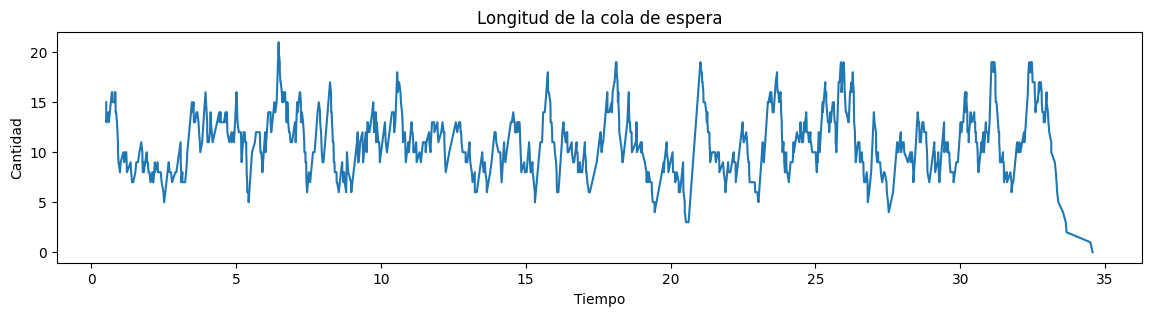

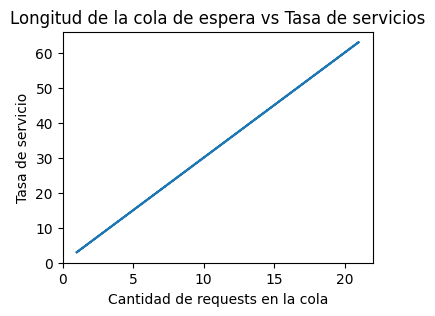

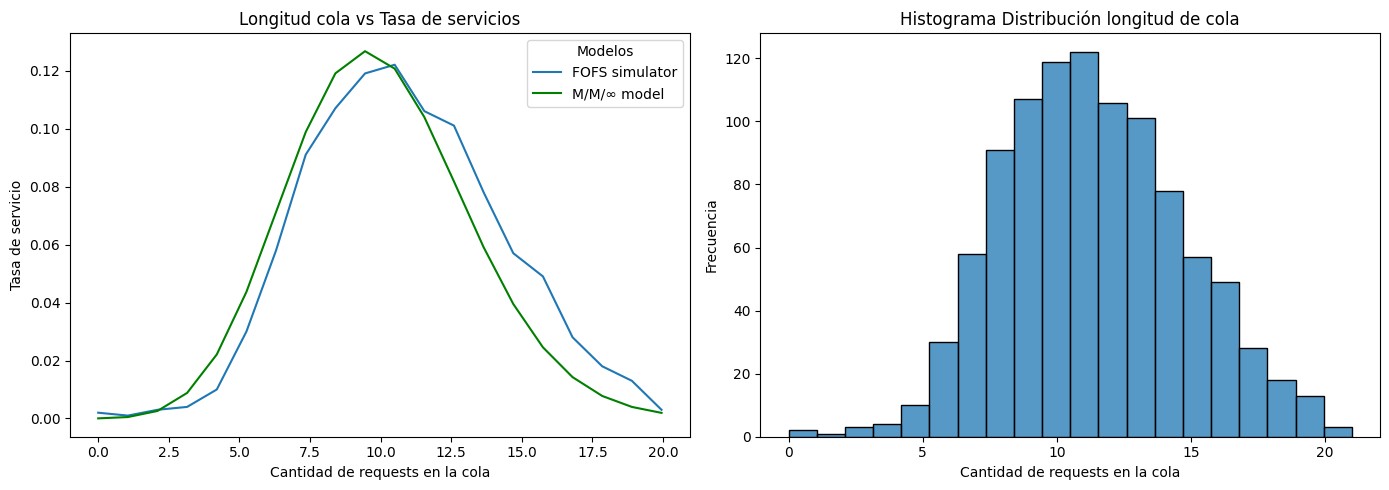

----------------------------------------------------------------------------------------------



=> Arribos: 1000, Tasa arribo: 3 req/día, Tasa servicios: 10 req/día


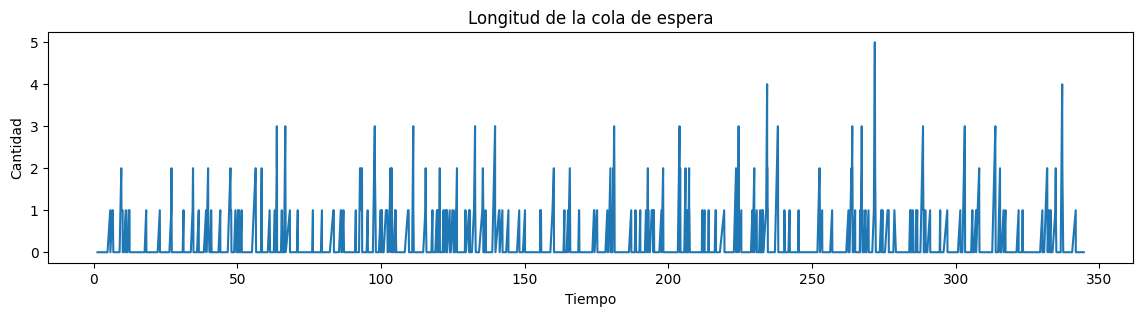

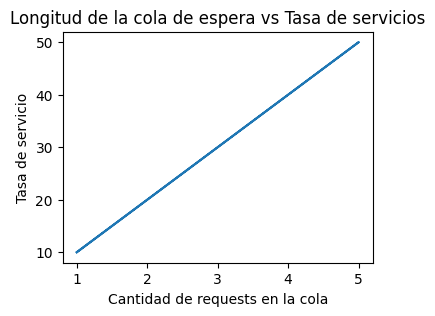

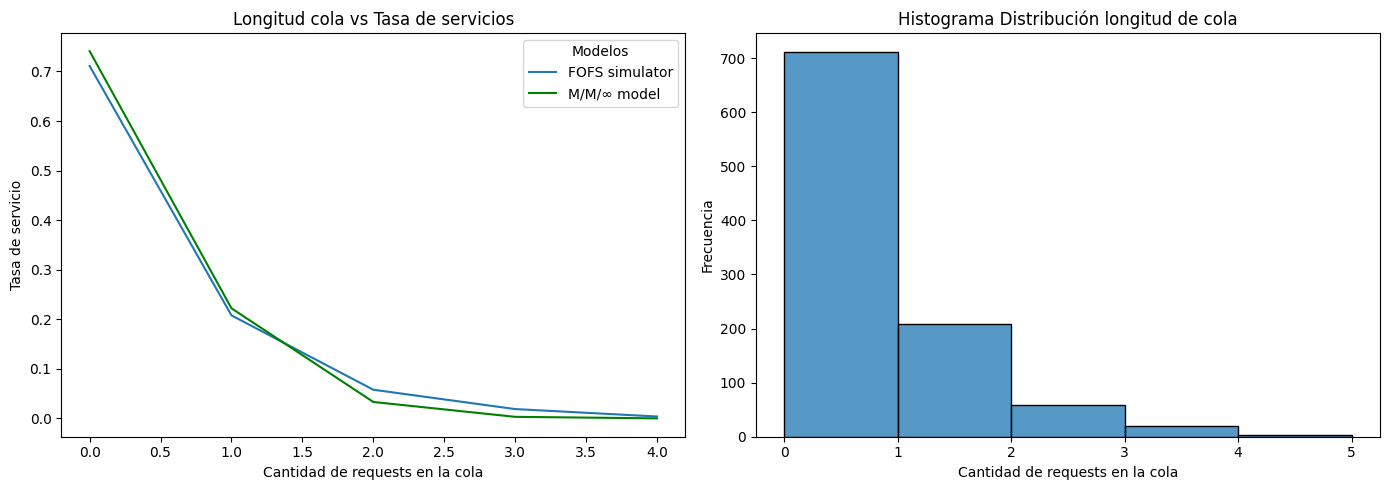

----------------------------------------------------------------------------------------------



=> Arribos: 1000, Tasa arribo: 10 req/día, Tasa servicios: 10 req/día


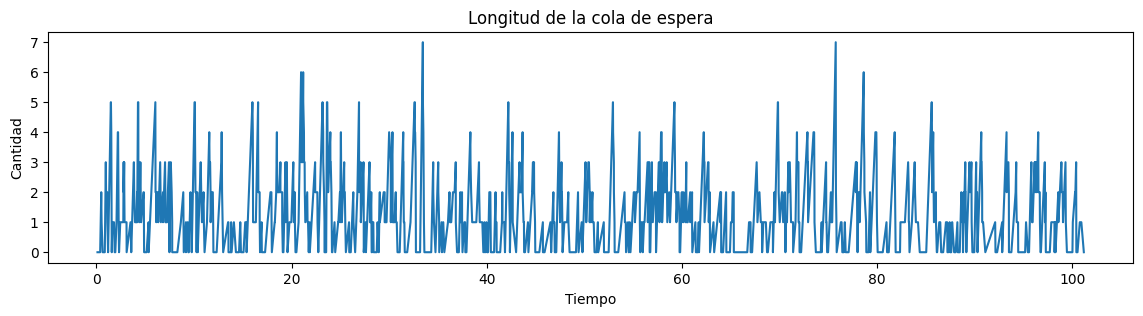

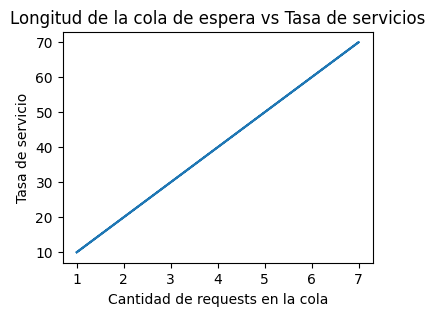

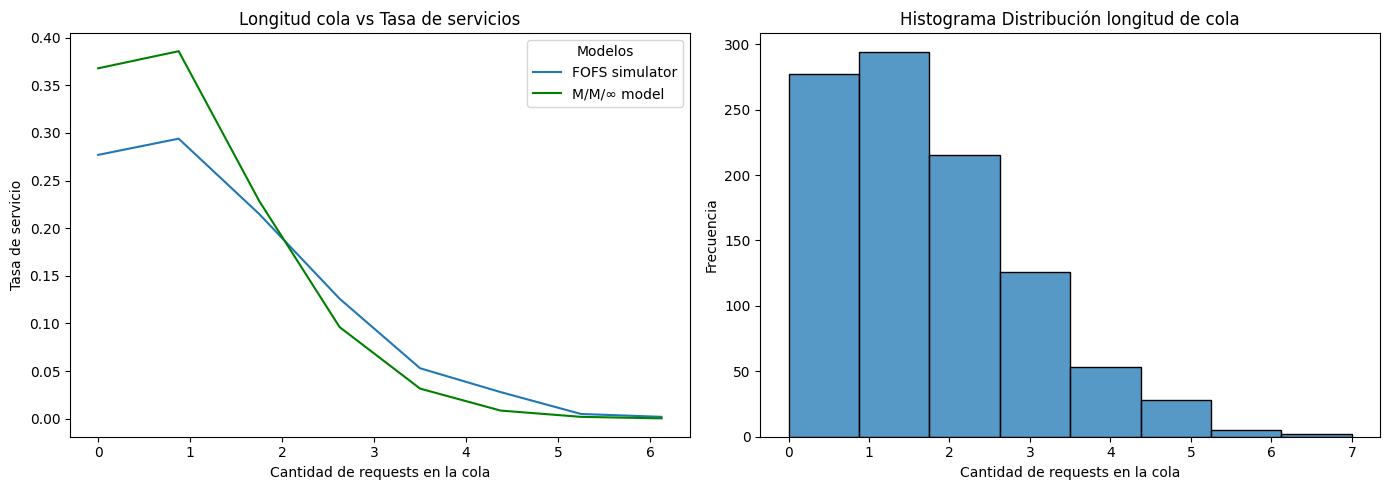

----------------------------------------------------------------------------------------------





In [ ]:
#[tasa de arribo, tasa de servicio, bins adecuados para graficar] 
tasas = [[30,3,20], [3,10, 5], [10,10, 8]]
arribos = 1000
for tasa in tasas:
    cola = SimuladorCola(tasa[0], tasa[1], arribos).simular()
    print(f"\033[1m=> Arribos: {arribos}, Tasa arribo: {tasa[0]} req/día, Tasa servicios: {tasa[1]} req/día\033[0m")
    cola.graficar(tasa[2])
    print("----------------------------------------------------------------------------------------------\n\n\n")
    

## Ejercicio 3
Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos. \\
Se estima que el tiempo que transcurre entre cada llamada al servicio se puede modelar según una distribución exponencial con media de **4 segundos**. \\
Se debe decidir la arquitectura de base de datos a utilizar entre las dos siguientes: \\

1.   Utilizar 2 bases de datos distribuidas. \\
Con probabilidad **p = 0.7** las solicitudes son atendidas por la base 1 y con  probabilidad **q = 1 - p** son atendidos por la base de datos 2. \\
El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con medias, **0,7 seg** y **1 seg** respectivamente.
2.   Utilizar 1 base de datos central. \\
En este caso la demora en resolver una solicitud sigue una distribución exponencial con **0,8 segundos**.

Simular para cada opción 100.000 solicitudes procesadas, determinando: \\


*   El tiempo medio de espera entre que la solicitud llega y puede ser procesada (suponer que ninguna conexión cae por timeout).
*   La fracción de las solicitudes que no esperaron para ser procesadas.
*   Probar con distintos escenarios, modificando los parámetros del ejercicio.

El ejercicio se puede resolver utilizando Simpy o programación tradicional (a elección del grupo)

In [90]:
class SimuladorWebService:
  def __init__(self, _media_request, _medias_bases, _requests, _prob_base_1 = 1, _log=True):
    self.media_request = _media_request
    self.prob_base_1 = _prob_base_1
    self.distribuida = False
    self.log = _log
    self.media_base_1 = _medias_bases[0]
    if len(_medias_bases) == 2:
      self.distribuida = True
      self.media_base_2 = _medias_bases[1]

    self.requests_totales = _requests
    self.capacidad_servicio = 1
    self.tiempos = []
    self.request_en_espera = []
    self.tiempos_de_espera = []
    self.tiempos_de_atencion = []

  def generar_requests(self, env, bases):
    requests = 0
    for request in range(0, self.requests_totales):
      yield env.timeout(np.random.exponential(self.media_request))
      now = env.now

      n = 1
      if self.distribuida:  
        prob = np.random.uniform()
        if prob >= self.prob_base_1:
          n = 2

      if self.log: print(f"Request {request + 1}: Pido datos en tiempo {now} a base {n}")

      self.tiempos_de_espera.append(now)
      self.tiempos_de_atencion.append(now)
      
      env.process(self.base_i(request, env, bases[n - 1], n))

  def base_i(self, request_i, env, res, n):
    request = res.request()
    # Aguarda liberacion del recurso
    yield request

    now = env.now

    #obtengo el tiempo de espera de cada request
    self.tiempos_de_espera[request_i] = now - self.tiempos_de_espera[request_i]

    if n == 1:
      request_time = np.random.exponential(self.media_base_1)
    else:
      request_time = np.random.exponential(self.media_base_2)

    if self.log: print(f"Empiezo a resolver query {request_i + 1} en base {n}. Inició en tiempo {now}, esperé {self.tiempos_de_espera[request_i]}, demoraré {request_time}")
    yield env.timeout(request_time)

    now = env.now
    if self.log: print(f"Fin de la query {request_i + 1} en base {n}. Tiempo {now}. Quedan en espera {len(res.queue)}")

    # Guardamos datos
    self.tiempos.append(now)
    # Calculo los tiempos de atencion
    self.tiempos_de_atencion[request_i] = now - self.tiempos_de_atencion[request_i]
    self.request_en_espera.append(len(res.queue))
    # Libera el recurso
    yield res.release(request)

  def obtener_valores_medios(self):
    tiempo_medio_atencion = sum(self.tiempos_de_atencion) / self.requests_totales
    ocupacion_media = self.requests_totales/self.tiempos[-1]
    tiempo_medio_espera = sum(self.tiempos_de_espera)/self.requests_totales

    # Primero filtramos los que tenga tiempo de espera igual a 0
    request_inmediatas = list(filter(lambda x: x == 0, self.tiempos_de_espera))

    # Obtenemos la faccion deseada
    fraccion_inmediatas = len(request_inmediatas)/self.requests_totales

    return tiempo_medio_atencion, ocupacion_media, tiempo_medio_espera, fraccion_inmediatas

  def simular(self):
    env = simpy.Environment()
    bases = [simpy.Resource(env, capacity=self.capacidad_servicio)]
    if self.distribuida:
      bases.append(simpy.Resource(env, capacity=self.capacidad_servicio))

    env.process(self.generar_requests(env, bases))
    env.run()
    return self.tiempos, self.tiempos_de_atencion, self.tiempos_de_espera

Declaramos las variables del ejercicio

In [91]:
media_request = 4
media_base_distribuida_1 = 0.7
media_base_distribuida_2 = 1
media_base_unica = 0.8
request_totales = 100000
prob_base_1 = 0.7

### Simulamos la base distribuida

In [92]:
simulacion_base_distribuida = SimuladorWebService(media_request, [media_base_distribuida_1, media_base_distribuida_2], request_totales, prob_base_1)
tiempos, tiempos_de_atencion, tiempos_de_espera = simulacion_base_distribuida.simular()

Streaming output truncated to the last 5000 lines.
Empiezo a resolver query 98334 en base 1. Inició en tiempo 392718.84760137985, esperé 0.3196842987672426, demoraré 1.7488120793696402
Fin de la query 98334 en base 1. Tiempo 392720.5964134592. Quedan en espera 0
Request 98335: Pido datos en tiempo 392730.5578613961 a base 1
Empiezo a resolver query 98335 en base 1. Inició en tiempo 392730.5578613961, esperé 0.0, demoraré 0.1742703520987127
Fin de la query 98335 en base 1. Tiempo 392730.7321317482. Quedan en espera 0
Request 98336: Pido datos en tiempo 392732.3173288169 a base 2
Empiezo a resolver query 98336 en base 2. Inició en tiempo 392732.3173288169, esperé 0.0, demoraré 1.5585127419309854
Fin de la query 98336 en base 2. Tiempo 392733.87584155885. Quedan en espera 0
Request 98337: Pido datos en tiempo 392736.2136586694 a base 2
Empiezo a resolver query 98337 en base 2. Inició en tiempo 392736.2136586694, esperé 0.0, demoraré 0.27007933493889735
Fin de la query 98337 en base 2. Tie

Obtenemos los valores medios

In [93]:
tiempo_medio_atencion, ocupacion_media, tiempo_medio_espera, fraccion_inmediatas = simulacion_base_distribuida.obtener_valores_medios()
tiempo_medio_atencion, ocupacion_media, tiempo_medio_espera, fraccion_inmediatas

(0.8769980283145582, 0.2504844479267066, 0.09119434407983688, 0.89356)

Vemos que el tiempo medio de espera de la solicitud es muy bajo, esto se debe a que el tiempo medio entre la llegada de solicitudes es mayor a los tiempos medios de procesado en las bases de datos.

In [94]:
tiempo_medio_espera

0.09119434407983688

Vemos que este valor es alto, como se menciono anteriormente, esto se debe a la gran diferencia entre el tiempo entre arribo de solicitudes medio y el tiempo de procesamiento de las bases.

In [95]:
fraccion_inmediatas

0.89356

### Ahora variamos un poco los parametros

Disminuimos el tiempo medio de arribo de las request, lo esperado seria que aumente el tiempo promedio de espera y a su vez disminuya la fraccion de requests procesadas inmediatamente.

In [96]:
nueva_media_request = 1
variante_1_base_distribuida = SimuladorWebService(nueva_media_request, [media_base_distribuida_1, media_base_distribuida_2], request_totales, prob_base_1)
tiempos, tiempos_de_atencion, tiempos_de_espera = variante_1_base_distribuida.simular()

Streaming output truncated to the last 5000 lines.
Fin de la query 98334 en base 1. Tiempo 98181.79116903279. Quedan en espera 0
Request 98335: Pido datos en tiempo 98182.40087818554 a base 1
Empiezo a resolver query 98335 en base 1. Inició en tiempo 98182.40087818554, esperé 0.0, demoraré 0.07732985993649882
Fin de la query 98335 en base 1. Tiempo 98182.47820804548. Quedan en espera 0
Fin de la query 98333 en base 2. Tiempo 98182.66908783665. Quedan en espera 0
Request 98336: Pido datos en tiempo 98182.8465810448 a base 1
Empiezo a resolver query 98336 en base 1. Inició en tiempo 98182.8465810448, esperé 0.0, demoraré 0.2872335974553314
Fin de la query 98336 en base 1. Tiempo 98183.13381464225. Quedan en espera 0
Request 98337: Pido datos en tiempo 98187.67022195998 a base 1
Empiezo a resolver query 98337 en base 1. Inició en tiempo 98187.67022195998, esperé 0.0, demoraré 0.33777979715150225
Fin de la query 98337 en base 1. Tiempo 98188.00800175713. Quedan en espera 0
Request 98338: P

Obtenemos los valores medios de vuelta y comparamos

In [97]:
_, _, tiempo_medio_espera, fraccion_inmediatas = variante_1_base_distribuida.obtener_valores_medios()
print("Nuevo tiempo de espera: " + str(tiempo_medio_espera))
print("Nueva fraccion de request inmediatas: " + str(fraccion_inmediatas))

Nuevo tiempo de espera: 0.5963515254210758
Nueva fraccion de request inmediatas: 0.56582


Vemos que se cumplio lo esperado

Que pasa si variamos la probabilidad de que la request sea atendida por la base 1.

In [98]:
tiempos_medio = []
fracciones_inmediatas = []
probabilidades = np.arange(0.0, 1.01, 0.01)

for nueva_p in probabilidades:
  variante_2_base_distribuida = SimuladorWebService(media_request, [media_base_distribuida_1, media_base_distribuida_2], 10000, nueva_p, False)
  variante_2_base_distribuida.simular()
  _, _, tiempo_medio_espera, fraccion_inmediatas = variante_2_base_distribuida.obtener_valores_medios()
  tiempos_medio.append(tiempo_medio_espera)
  fracciones_inmediatas.append(fraccion_inmediatas)

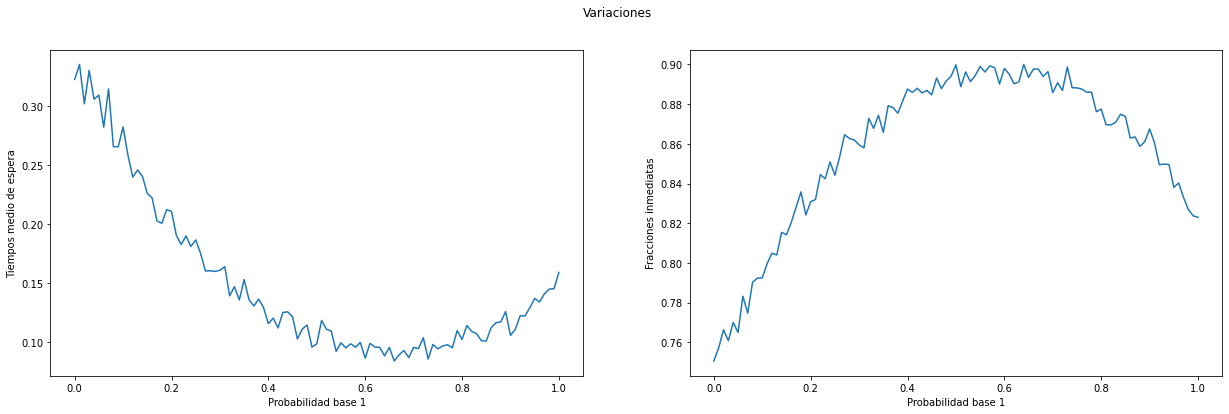

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[21 , 6])
fig.suptitle('Variaciones')
ax1.set(xlabel='Probabilidad base 1', ylabel='Tiempos medio de espera')
ax2.set(xlabel='Probabilidad base 1', ylabel='Fracciones inmediatas')
ax1.plot(probabilidades, tiempos_medio)
ax2.plot(probabilidades, fracciones_inmediatas)

Podemos observar 2 fenomenos: 
1.   Conforme va aumentando la probabilidad de caer en la base 1, los tiempos medios de espera y las fracciones inmediatas van mejorando, esto se debe a que la base 1 tiene menor tiempo medio de atencion que la base 2.
2.   Luego llega a un punto en el que empieza a aumentar los valores (0.7 aproximadamente), esto puede deberse a que cada vez se sigue aumentando la probabilidad de atender la request con la base 1 se va perdiendo el factor de paralelismo que tiene una base distribuida.

### Simulamos la base no distribuida

In [100]:
base_no_distribuida = SimuladorWebService(media_request, [media_base_unica], request_totales)
tiempos, tiempos_de_atencion, tiempos_de_espera = base_no_distribuida.simular()

Streaming output truncated to the last 5000 lines.
Empiezo a resolver query 98334 en base 1. Inició en tiempo 394394.32860525005, esperé 0.0, demoraré 3.294769767158103
Fin de la query 98334 en base 1. Tiempo 394397.6233750172. Quedan en espera 0
Request 98335: Pido datos en tiempo 394412.0376826831 a base 1
Empiezo a resolver query 98335 en base 1. Inició en tiempo 394412.0376826831, esperé 0.0, demoraré 0.8458519892553991
Fin de la query 98335 en base 1. Tiempo 394412.8835346723. Quedan en espera 0
Request 98336: Pido datos en tiempo 394414.47149393515 a base 1
Empiezo a resolver query 98336 en base 1. Inició en tiempo 394414.47149393515, esperé 0.0, demoraré 0.27215429543964803
Fin de la query 98336 en base 1. Tiempo 394414.7436482306. Quedan en espera 0
Request 98337: Pido datos en tiempo 394415.1685091965 a base 1
Empiezo a resolver query 98337 en base 1. Inició en tiempo 394415.1685091965, esperé 0.0, demoraré 0.4502653122795048
Fin de la query 98337 en base 1. Tiempo 394415.6187

Obtenemos los valores medios

In [101]:
tiempo_medio_atencion, ocupacion_media, tiempo_medio_espera, fraccion_inmediatas = base_no_distribuida.obtener_valores_medios()
tiempo_medio_atencion, ocupacion_media, tiempo_medio_espera, fraccion_inmediatas

(1.0082714052672315, 0.249228760825447, 0.20420529997909787, 0.7991)

Vemos que el tiempo de espera medio sigue siendo bajo, por las mimas razones que la base distribuida.

In [102]:
tiempo_medio_espera

0.20420529997909787

Lo mismo pasa con la fracción de las solicitudes que no esperaron para ser procesadas.

In [103]:
fraccion_inmediatas

0.7991

Vemos si se cumple la Formula de Little

In [104]:
print("¿" + str(tiempo_medio_atencion/media_request) + " = " + str(ocupacion_media) + "?")

¿0.25206785131680787 = 0.249228760825447?


Podemos observar que estos son muy cercanos ademas el resto de valores tambien se acercan a los teoricos.

In [116]:
print("Tiempo medio de atencion simulado: " + str(tiempo_medio_atencion))
print("Tiempo medio de atencion Teorico: " + str(1 / (1/media_base_unica - 1/media_request)))

rho = media_base_unica/media_request
print("Ocupacion media simulada: " + str(ocupacion_media))
print("Ocupacion media teorica: " + str(rho / (1 - rho)))

Tiempo medio de atencion simulado: 1.0082714052672315
Tiempo medio de atencion Teorico: 1.0
Ocupacion media simulada: 0.249228760825447
Ocupacion media teorica: 0.25


### Ahora variamos un poco los parametros

Vemos que pasa si variamos el tiempo medio de llegada de cada request.

In [105]:
tiempos_medio = []
fracciones_inmediatas = []
medias_requests = np.arange(0.0, 2, 0.02)

for media_r in medias_requests:
  variante_base_no_distribuida = SimuladorWebService(media_r, [media_base_unica], 10000, _log=False)
  variante_base_no_distribuida.simular()
  _, _, tiempo_medio_espera, fraccion_inmediatas = variante_base_no_distribuida.obtener_valores_medios()
  tiempos_medio.append(tiempo_medio_espera)
  fracciones_inmediatas.append(fraccion_inmediatas)

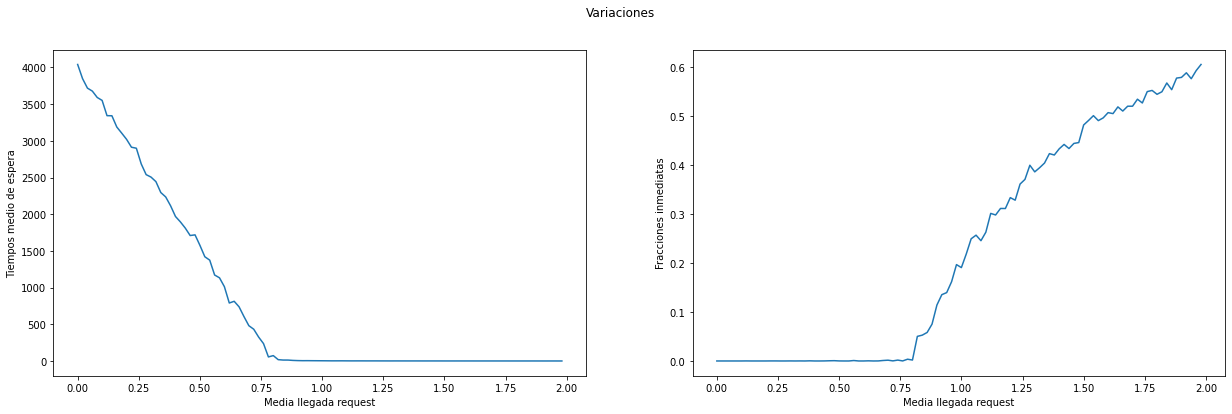

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[21 , 6])
fig.suptitle('Variaciones')
ax1.set(xlabel='Media llegada request', ylabel='Tiempos medio de espera')
ax2.set(xlabel='Media llegada request', ylabel='Fracciones inmediatas')
ax1.plot(medias_requests, tiempos_medio)
ax2.plot(medias_requests, fracciones_inmediatas)

Podemos observar, sin sorpresa alguna, que conforme va aumentando el tiempo medio de llegada de request los valores mejoran, esto se debe a que a mayor sea este parametro es mas probable que la request sera resuelta antes de que llegue la siguiente.

## Ejercicio 4

Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de
reciclador de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo
pueda retirar otro cliente).
El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que
posee dos compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
Esto presenta los siguientes problemas:

* Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo aunque tenga en el compartimento de depósitos.
* Si el compartimento que recibe los depósitos se completa, no puede recibir más.

La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sólo
acepta cambiarlo si este porcentaje disminuye.

Por simplicidad suponer que el cajero sólo expende billetes de $100, tiene una capacidad máxima de 2000
billetes, y comienza el día con su carga completa.
Si un cliente quiere extraer dinero y el cajero no cuenta con la suma suficiente, se va del mismo sin retirar nada.
Algo similar ocurre cuando un cliente desea depositar efectivo y la capacidad máxima de billetes en el cajero fue
alcanzada, retirándose sin poder depositar.

En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:
Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban.
El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90
segundos.
Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme
[3,50].
Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales.
Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos.
Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando
una distribución uniforme [10,110].

* a.Simular 1000 días completos de 24 hrs.
* b. Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.
* c. Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)
* d. ¿Recomienda a la entidad que implemente el cambio de cajero?

In [ ]:
TIEMPO_MIL_DIAS = 60*60*24*1000
TIEMPO_UN_DIA = 60*24
tasa_arribos = 1/10
TASA_SERVICIO_EFECTIVO = 1/1.5
TASA_SERVICIO_DEPOSITO = 1/5

In [ ]:
class ClienteEfectivo:
    def __init__(self):
        #self.tiempoCajero = np.random.exponential(scale=1/TIEMPO_CLIENTE_GRUPO_1) #buscar lo de la exponencial
        self.cantidadRetirada = np.random.uniform(3,50)//1 #buscar lo de la uniforme
    
    def billetesRetirados(self):
        return self.cantidadRetirada
            
class ClienteDeposito:
    def __init__(self):
        #self.tiempoCajero = np.random.exponential(scale=1/TIEMPO_CLIENTE_GRUPO_2) #buscar lo de la exponencial
        self.cantidadDepositada = np.random.uniform(10,110)//1  #buscar lo de la uniforme
        
    def billetesDepositados(self):
        return self.cantidadDepositada

In [ ]:
class SimularCajeroReciclador:
    
    def __init__(self,_tasa_arribos,_tasa_servicio_efectivo, _tasa_servicio_deposito):
        self.cantidadBilletes = 2000
        self.listaBilletes = []
        self.listaBilletes.append(2000)
        self.tiempos = []
        self.tiempos.append(0)
        self.tasa_arribos = _tasa_arribos
        self.tasa_servicio_efectivo = _tasa_servicio_efectivo
        self.tasa_servicio_deposito = _tasa_servicio_deposito
        self.capacidad_servicio = 1
        self.request_en_espera = []
        self.arribos = 0
        self.cantidad_clientes_insatisfechos = 0
        self.mediaClientes = []
                
    def depositar(self,x,env,tasa_servicio):
        if (self.cantidadBilletes + x > 2000):
            print("No se puede realizar el deposito") 
            self.cantidad_clientes_insatisfechos += 1
            self.listaBilletes.append(self.cantidadBilletes)
            
        else:
            self.cantidadBilletes += x
            print("Se realizo el deposito. Dinero restante:" + str(self.cantidadBilletes))
            self.listaBilletes.append(self.cantidadBilletes)
            
            
    def retirar(self,x,env,tasa_servicio):
        print(f"Retirando efectivo. Inició en tiempo {env.now}")
        if (self.cantidadBilletes - x < 0):
            print("No se puede realizar la extraccion")
            self.cantidad_clientes_insatisfechos += 1
            self.listaBilletes.append(self.cantidadBilletes)
        else:
            self.cantidadBilletes -= x
            print("Se realizo el retiro. Dinero restante:" + str(self.cantidadBilletes))
            self.listaBilletes.append(self.cantidadBilletes)
        
    def generar_arribos_requests(self, env, res,cantidadDeDias):
        for i in range(1,cantidadDeDias+1): #cantidad de dias. Aca lo hice 
            while env.now < (TIEMPO_UN_DIA)*i:
                prob = random.random()
                yield env.timeout(np.random.exponential(1/self.tasa_arribos))
                self.arribos += 1

                if (prob < 0.75):
                    print(f"Cliente {self.arribos}:Cliente para retirar arribó en tiempo {env.now}")
                    env.process(self.servicio_efectivo(env, res, self.tasa_servicio_efectivo))

                else:
                    print(f"Cliente {self.arribos}:Cliente para depositar arribó en tiempo {env.now}")
                    env.process(self.servicio_deposito(env, res, self.tasa_servicio_deposito))
                
            self.cantidadBilletes = 2000
            self.listaBilletes.append(2000)
            self.tiempos.append(TIEMPO_UN_DIA*i)

    def servicio_efectivo(self, env, res,tasa_servicio):
        # Aguarda liberacion del recurso
        request = res.request()
        yield request
        
        tiempoLlegada = env.now
        
        nuevoCliente = ClienteEfectivo()
        self.retirar(nuevoCliente.billetesRetirados(),env,tasa_servicio)
        
        yield env.timeout(np.random.exponential(1/tasa_servicio))
        self.tiempos.append(env.now)
        self.mediaClientes.append(env.now - tiempoLlegada)
        
        print(f"El cliente retiro. Tiempo {env.now}. Quedan en espera {len(res.queue)}")
        #Guardamos datos
        self.request_en_espera.append(len(res.queue))
        # Libera el recurso
        yield res.release(request)

    def servicio_deposito(self, env, res,tasa_servicio):
        # Aguarda liberacion del recurso
        request = res.request()
        yield request
        
        tiempoLlegada = env.now
        
        nuevoCliente = ClienteDeposito()
        self.depositar(nuevoCliente.billetesDepositados(),env,tasa_servicio)
        
        yield env.timeout(np.random.exponential(1/tasa_servicio))
        self.tiempos.append(env.now)
        self.mediaClientes.append(env.now - tiempoLlegada)

        print(f"El cliente deposito y se retiro. Tiempo {env.now}. Quedan en espera {len(res.queue)}")
        #Guardamos datos
        self.request_en_espera.append(len(res.queue))
        # Libera el recurso
        yield res.release(request)

    def simular(self,cantidadDeDias):
        env = simpy.Environment() #Entorno de simpy
        recurso = simpy.Resource(env, capacity=self.capacidad_servicio) #La Cola de prioridad
        env.process(self.generar_arribos_requests(env, recurso,cantidadDeDias))
        env.run()
        return self.tiempos, self.listaBilletes
    
    def efectividad(self):
        return (self.cantidad_clientes_insatisfechos/self.arribos)*1000

    def listaCantidadBilletes(self):
        return self.listaBilletes
    
    def mediaCliente(self):
        contador = 0
        for media in self.mediaClientes:
            contador += media
        return(contador/self.arribos)
    
def grafico_billetes_vs_tiempo(tiempos, listaBilletes):
    plt.plot(tiempos, listaBilletes, '-')
    plt.title("Cantidad Billetes en el cajero")
    plt.ylabel("Cantidad")
    plt.xlabel("Tiempo(dias)")
    plt.show()

### Simulacion de 1 dia.

In [ ]:
cajero = SimularCajeroReciclador(tasa_arribos, TASA_SERVICIO_EFECTIVO,TASA_SERVICIO_EFECTIVO)
t, b = cajero.simular(1)


Cliente 1:Cliente para retirar arribó en tiempo 1.691744389877992
Retirando efectivo. Inició en tiempo 1.691744389877992
Se realizo el retiro. Dinero restante:1989.0
El cliente retiro. Tiempo 2.108697757032545. Quedan en espera 0
Cliente 2:Cliente para retirar arribó en tiempo 5.155183180810324
Retirando efectivo. Inició en tiempo 5.155183180810324
Se realizo el retiro. Dinero restante:1948.0
El cliente retiro. Tiempo 5.96039108818067. Quedan en espera 0
Cliente 3:Cliente para retirar arribó en tiempo 10.327114160877027
Retirando efectivo. Inició en tiempo 10.327114160877027
Se realizo el retiro. Dinero restante:1928.0
Cliente 4:Cliente para depositar arribó en tiempo 12.242788275302612
Cliente 5:Cliente para retirar arribó en tiempo 12.296827606842047
El cliente retiro. Tiempo 13.236750886508517. Quedan en espera 2
Se realizo el deposito. Dinero restante:1996.0
El cliente deposito y se retiro. Tiempo 15.117667355056724. Quedan en espera 1
Retirando efectivo. Inició en tiempo 15.117667

In [ ]:
print("Porcentaje de clientes insatisfechos: "+str(cajero.efectividad())+"%")
print("Tiempo Medio de cada cliente en el cajero: "+str(cajero.mediaCliente()))

Porcentaje de clientes insatisfechos: 15.625%
Tiempo Medio de cada cliente en el cajero: 1.4086377909711432


###  Cantidad de billetes en el cajero luego de cada transacción.

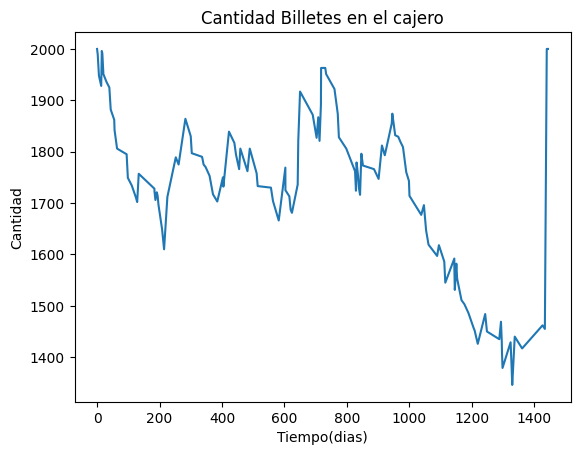

In [ ]:
grafico_billetes_vs_tiempo(t,b) #Esto es en dos dias.

### Simulacion de 1000 dias.

In [ ]:
cajero = SimularCajeroReciclador(tasa_arribos, TASA_SERVICIO_EFECTIVO,TASA_SERVICIO_EFECTIVO)
t, b = cajero.simular(1000)

Cliente 1:Cliente para depositar arribó en tiempo 7.0569689346994116
No se puede realizar el deposito
El cliente deposito y se retiro. Tiempo 7.2657016689822305. Quedan en espera 0
Cliente 2:Cliente para retirar arribó en tiempo 20.907795082996426
Retirando efectivo. Inició en tiempo 20.907795082996426
Se realizo el retiro. Dinero restante:1968.0
El cliente retiro. Tiempo 22.192150275171937. Quedan en espera 0
Cliente 3:Cliente para retirar arribó en tiempo 37.114920716826056
Retirando efectivo. Inició en tiempo 37.114920716826056
Se realizo el retiro. Dinero restante:1943.0
El cliente retiro. Tiempo 39.393156026082195. Quedan en espera 0
Cliente 4:Cliente para depositar arribó en tiempo 49.092726277867435
No se puede realizar el deposito
El cliente deposito y se retiro. Tiempo 50.10256463180331. Quedan en espera 0
Cliente 5:Cliente para retirar arribó en tiempo 52.23908621991473
Retirando efectivo. Inició en tiempo 52.23908621991473
Se realizo el retiro. Dinero restante:1937.0
El clie

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



El cliente retiro. Tiempo 1288638.891813376. Quedan en espera 0
Cliente 128852:Cliente para retirar arribó en tiempo 1288647.3161221116
Retirando efectivo. Inició en tiempo 1288647.3161221116
Se realizo el retiro. Dinero restante:1064.0
El cliente retiro. Tiempo 1288648.2216449913. Quedan en espera 0
Cliente 128853:Cliente para retirar arribó en tiempo 1288648.8631468245
Retirando efectivo. Inició en tiempo 1288648.8631468245
Se realizo el retiro. Dinero restante:1054.0
El cliente retiro. Tiempo 1288650.0438622048. Quedan en espera 0
Cliente 128854:Cliente para retirar arribó en tiempo 1288652.4817254331
Retirando efectivo. Inició en tiempo 1288652.4817254331
Se realizo el retiro. Dinero restante:1047.0
El cliente retiro. Tiempo 1288654.7455950016. Quedan en espera 0
Cliente 128855:Cliente para depositar arribó en tiempo 1288659.355500716
Se realizo el deposito. Dinero restante:1131.0
El cliente deposito y se retiro. Tiempo 1288659.4549792716. Quedan en espera 0
Cliente 128856:Cliente 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print("Porcentaje de clientes insatisfechos: "+str(cajero.efectividad())+"%")
print("Tiempo Medio de cada cliente en el cajero: "+str(cajero.mediaCliente()))

Porcentaje de clientes insatisfechos: 17.359083451516923%
Tiempo Medio de cada cliente en el cajero: 1.50087678504044


En el cajero reciclador se encuentra una mejoria comparando con el cajero clasico, en donde se bajo de un 20% de clientes insatisfechos a un 17% aproximadamente